## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

## 2. Load and Explore Historical Data

In [ ]:
# Load BTCUSD 15m HA data exported from MT5
filename = "BTCUSD_15m_HA_data.csv"
df = pd.read_csv(filename, sep=',')
df['Time'] = pd.to_datetime(df['Time'])

print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

## 3. Calculate Heikin Ashi Candle Properties

In [ ]:
# Calculate HA candle properties
df['HA_Body'] = df['HA_Close'] - df['HA_Open']
df['HA_High_Low'] = df['HA_High'] - df['HA_Low']
df['HA_Range'] = df['HA_High'] - df['HA_Low']

# Close price momentum
df['Close_Change'] = df['HA_Close'].diff()
df['Close_Pct_Change'] = df['HA_Close'].pct_change()

# Volume analysis
df['Volume_Change'] = df['Volume'].diff()
df['Volume_MA'] = df['Volume'].rolling(5).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']

print("HA properties calculated")

## 4. K-Means Clustering

In [ ]:
# Calculate K-means clusters (rolling 252-bar window)
window = 252
n_bars = len(df)

# Pre-allocate numpy arrays (much faster than .loc in a loop)
clusters = np.full(n_bars, np.nan)
densities = np.full(n_bars, np.nan)

# Cache close prices as numpy array (avoid repeated .iloc conversions)
close_prices = df['HA_Close'].values.reshape(-1, 1)

for i in range(window, n_bars):
    # Get rolling window (numpy slicing is faster)
    window_prices = close_prices[i-window:i]
    
    # Fit K-means with 3 clusters
    # Optimized parameters: n_init=2 (instead of 10), max_iter limit
    kmeans = KMeans(
        n_clusters=3,
        n_init=2,           # Reduced from 10 (still stable)
        max_iter=100,       # Add iteration limit for convergence
        random_state=42,
        tol=1e-3            # Slightly relax tolerance
    )
    cluster_labels = kmeans.fit_predict(window_prices)
    
    # Current cluster
    current_cluster = cluster_labels[-1]
    clusters[i] = current_cluster
    
    # Cluster density (pure numpy is faster)
    cluster_count = np.sum(cluster_labels == current_cluster)
    densities[i] = (cluster_count / window) * 100

# Assign back to dataframe
df['Cluster'] = clusters
df['Cluster_Density'] = densities

print("K-Means clustering complete")
print(f"Processed {n_bars - window} rolling windows")

## 5. Count Consecutive HA Bars (3+ for pattern)

In [ ]:
def count_consecutive_bars(df, window=3):
    up_signal = []
    down_signal = []
    consecutive_up = 0
    consecutive_down = 0
    
    for i in range(len(df)):
        if i == 0:
            up_signal.append(0)
            down_signal.append(0)
            continue
        
        # Check if current bar is up or down compared to previous
        if df.loc[i, 'HA_Close'] > df.loc[i-1, 'HA_Close']:
            consecutive_up += 1
            consecutive_down = 0
        elif df.loc[i, 'HA_Close'] < df.loc[i-1, 'HA_Close']:
            consecutive_down += 1
            consecutive_up = 0
        else:
            consecutive_up = 0
            consecutive_down = 0
        
        up_signal.append(1 if consecutive_up >= window else 0)
        down_signal.append(1 if consecutive_down >= window else 0)
    
    return up_signal, down_signal

df['HA_Up_Signal'], df['HA_Down_Signal'] = count_consecutive_bars(df, window=3)

print(f"Up signals: {df['HA_Up_Signal'].sum()}")
print(f"Down signals: {df['HA_Down_Signal'].sum()}")
print(f"\nExample signals (last 20 bars):")
print(df[['HA_Close', 'HA_Up_Signal', 'HA_Down_Signal']].tail(20))

## 6. Create Target Label (10 bars ahead for day trading)

In [ ]:
# Create label: predict direction 10 bars ahead (~2.5 hours on M15)
# This converts from scalping (1-bar) to day trading (2.5+ hours)
# 1: price goes up, -1: price goes down

shift_bars = 10  # 10 bars * 15min = 2.5 hours on M15

df['Next_Close'] = df['HA_Close'].shift(-shift_bars)
df['Price_Change'] = df['Next_Close'] - df['HA_Close']

# Threshold for up/down classification
threshold = df['Price_Change'].abs().std() * 0.1  # Use 10% of std as threshold

def label_direction(row):
    if pd.isna(row['Price_Change']):
        return np.nan
    elif row['Price_Change'] > threshold:
        return 1  # Up
    elif row['Price_Change'] < -threshold:
        return -1  # Down
    else:
        return 0  # Neutral (remove from training)

df['Trend'] = df.apply(label_direction, axis=1)

# Remove NaN and neutral values and last 10 rows (not enough bars ahead)
df_clean = df[df['Trend'].notna() & (df['Trend'] != 0)].copy()
df_clean = df_clean[:-shift_bars].copy()

print(f"Total bars: {len(df)}")
print(f"Bars after cleanup: {len(df_clean)}")
print(f"Prediction horizon: {shift_bars} bars ahead (~{shift_bars * 15 / 60:.1f} hours on M15)")
print(f"\nLabel distribution:")
print(df_clean['Trend'].value_counts())
print(f"\nUp: {(df_clean['Trend'] == 1).sum()} ({(df_clean['Trend'] == 1).sum() / len(df_clean) * 100:.1f}%)")
print(f"Down: {(df_clean['Trend'] == -1).sum()} ({(df_clean['Trend'] == -1).sum() / len(df_clean) * 100:.1f}%)")

## 7. Engineer Features for XGBoost

In [ ]:
# Select features for the model
feature_cols = [
    'HA_Open', 'HA_High', 'HA_Low', 'HA_Close',  # HA candle prices
    'HA_Body', 'HA_Range',                        # HA candle properties
    'Close_Change', 'Close_Pct_Change',          # Price momentum
    'Volume', 'Volume_Change', 'Volume_MA',      # Volume features
    'Cluster', 'Cluster_Density',                # K-means features (rolling window)
    'HA_Up_Signal', 'HA_Down_Signal'             # HA pattern signals
]

# Prepare data
X = df_clean[feature_cols].copy()
y = df_clean['Trend'].copy()

# Handle NaN values
X = X.fillna(method='bfill').fillna(method='ffill')

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"Features shape: {X_scaled.shape}")
print(f"Feature columns: {feature_cols}")
print(f"\nFeature statistics:")
print(X_scaled.describe())

## 8. Train-Test Split

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set label distribution:")
print(y_train.value_counts())
print(f"\nTest set label distribution:")
print(y_test.value_counts())

## 9. Train XGBoost Model

In [ ]:
# Train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Convert labels to binary: -1 -> 0, 1 -> 1
y_train_binary = (y_train == 1).astype(int)
y_test_binary = (y_test == 1).astype(int)

# Train
model.fit(
    X_train, y_train_binary,
    eval_set=[(X_test, y_test_binary)],
    verbose=False
)

print("XGBoost model trained successfully")

## 10. Evaluate Model Performance

In [ ]:
# Make predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Convert back to ±1 format
y_pred_labels = np.where(y_pred == 1, 1, -1)
y_test_labels = np.where(y_test_binary == 1, 1, -1)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
roc_auc = roc_auc_score(y_test_binary, y_pred_proba[:, 1])

print("Model Performance on Test Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_binary, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred, target_names=['Down', 'Up']))

## 11. Feature Importance

In [ ]:
# Get feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

## 12. Save Model and Scaler

In [ ]:
# Save model
model.save_model('xgboost_ha15m_trend_model.json')
print("✓ Model saved: xgboost_ha15m_trend_model.json")

# Save scaler
joblib.dump(scaler, 'scaler_xgboost_ha15m.save')
print("✓ Scaler saved: scaler_xgboost_ha15m.save")

## 13. Generate Forecast

In [ ]:
# Generate predictions for entire dataset
X_all = df[feature_cols].fillna(method='bfill').fillna(method='ffill')
X_all_scaled = scaler.transform(X_all)
y_pred_all = model.predict(X_all_scaled)

# Convert to ±1
y_pred_all_labels = np.where(y_pred_all == 1, 1, -1)

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Time': df['Time'],
    'XGB_Prediction': y_pred_all_labels
})

forecast_df.to_csv('xgboost_ha15m_forecast.csv', index=False)
print("✓ Forecast saved: xgboost_ha15m_forecast.csv")
print(f"\nTotal predictions: {len(forecast_df)}")
print(f"Bullish: {(y_pred_all_labels == 1).sum()}")
print(f"Bearish: {(y_pred_all_labels == -1).sum()}")
print(f"\nSample (first 10):")
print(forecast_df.head(10))

## 14. Training Summary

In [ ]:
print("=" * 60)
print("XGBOOST TRAINING SUMMARY")
print("=" * 60)
print(f"\nModel: XGBoost Classifier (100 estimators, max_depth=6)")
print(f"Strategy: BTCUSD 15m Heiken Ashi + K-Means")
print(f"\nPrediction Target: {shift_bars} bars ahead (~{shift_bars * 15 / 60:.1f} hours)")
print(f"Purpose: Day trading (not scalping)")
print(f"\nTotal Features: {len(feature_cols)}")
print(f"Total Samples: {len(df)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"\nOutput Files:")
print(f"  1. xgboost_ha15m_trend_model.json")
print(f"  2. scaler_xgboost_ha15m.save")
print(f"  3. xgboost_ha15m_forecast.csv")
print("=" * 60)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


## 2. Load and Explore Historical Data

In [3]:
# Load BTCUSD 15m HA data exported from MT5
filename = "BTCUSD_15m_HA_data.csv"
df = pd.read_csv(filename, sep=',')
df['Time'] = pd.to_datetime(df['Time'])

print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

Data shape: (95764, 6)

First 5 rows:
                 Time       HA_Open   HA_High    HA_Low    HA_Close  Volume
0 2023-01-01 00:00:00  16520.510000  16529.87  16508.58  16519.8675       0
1 2023-01-01 00:15:00  16520.188750  16530.87  16506.51  16519.8000       0
2 2023-01-01 00:30:00  16519.994375  16533.31  16502.55  16518.7100       0
3 2023-01-01 00:45:00  16519.352188  16521.36  16505.79  16512.3350       0
4 2023-01-01 01:00:00  16515.843594  16530.62  16511.78  16520.6325       0

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95764 entries, 0 to 95763
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Time      95764 non-null  datetime64[ns]
 1   HA_Open   95764 non-null  float64       
 2   HA_High   95764 non-null  float64       
 3   HA_Low    95764 non-null  float64       
 4   HA_Close  95764 non-null  float64       
 5   Volume    95764 non-null  int64         
dtypes: datetime64

## 3. Calculate Heikin Ashi Candle Properties

In [4]:
# Calculate HA candle properties
df['HA_Body'] = df['HA_Close'] - df['HA_Open']
df['HA_High_Low'] = df['HA_High'] - df['HA_Low']
df['HA_Range'] = df['HA_High'] - df['HA_Low']

# Close price momentum
df['Close_Change'] = df['HA_Close'].diff()
df['Close_Pct_Change'] = df['HA_Close'].pct_change()

# Volume analysis
df['Volume_Change'] = df['Volume'].diff()
df['Volume_MA'] = df['Volume'].rolling(window=5).mean()

print("HA candle features created")
print(df[['HA_Open', 'HA_Close', 'HA_Body', 'HA_Range']].head(10))

HA candle features created
        HA_Open    HA_Close   HA_Body  HA_Range
0  16520.510000  16519.8675 -0.642500     21.29
1  16520.188750  16519.8000 -0.388750     24.36
2  16519.994375  16518.7100 -1.284375     30.76
3  16519.352188  16512.3350 -7.017188     15.57
4  16515.843594  16520.6325  4.788906     18.84
5  16518.238047  16522.3800  4.141953     11.86
6  16520.309023  16521.7050  1.395977     13.57
7  16521.007012  16530.3100  9.302988     22.10
8  16525.658506  16533.9875  8.328994     16.25
9  16529.823003  16535.3850  5.561997     12.22


## 4. Implement K-Means Clustering on Price

In [5]:
# Apply K-Means clustering to closing prices (rolling window, like LSTM/RF)
k_clusters = 3
window = 252  # 252 bars = ~1 week for M15

df['Cluster'] = np.nan
df['Cluster_Density'] = np.nan

for i in range(window, len(df)):
    close_prices = df['HA_Close'].iloc[i-window:i].values.reshape(-1, 1)
    
    # Fit K-means with 3 clusters
    kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(close_prices)
    
    # Get current bar cluster
    current_cluster = clusters[-1]
    df.loc[i, 'Cluster'] = current_cluster
    
    # Calculate cluster density
    cluster_count = np.sum(clusters == current_cluster)
    density = (cluster_count / window) * 100
    df.loc[i, 'Cluster_Density'] = density

print('K-Means clustering complete (rolling window approach)')
print(f'Cluster density range: {df["Cluster_Density"].min():.1f}% - {df["Cluster_Density"].max():.1f}%')

K-Means clustering complete (rolling window approach)
Cluster density range: 0.4% - 91.7%


## 5. Identify Consecutive HA Bars Pattern

In [6]:
# Count consecutive up/down bars in HA
def count_consecutive_bars(df, window=3):
    consecutive_up = 0
    consecutive_down = 0
    up_signal = []
    down_signal = []
    
    for i in range(len(df)):
        if i == 0:
            up_signal.append(0)
            down_signal.append(0)
            continue
        
        # Check if current bar is up or down compared to previous
        if df.loc[i, 'HA_Close'] > df.loc[i-1, 'HA_Close']:
            consecutive_up += 1
            consecutive_down = 0
        elif df.loc[i, 'HA_Close'] < df.loc[i-1, 'HA_Close']:
            consecutive_down += 1
            consecutive_up = 0
        else:
            consecutive_up = 0
            consecutive_down = 0
        
        up_signal.append(1 if consecutive_up >= window else 0)
        down_signal.append(1 if consecutive_down >= window else 0)
    
    return up_signal, down_signal

df['HA_Up_Signal'], df['HA_Down_Signal'] = count_consecutive_bars(df, window=3)

print(f"Up signals: {df['HA_Up_Signal'].sum()}")
print(f"Down signals: {df['HA_Down_Signal'].sum()}")
print(f"\nExample signals (last 20 bars):")
print(df[['HA_Close', 'HA_Up_Signal', 'HA_Down_Signal']].tail(20))

Up signals: 17763
Down signals: 17124

Example signals (last 20 bars):
          HA_Close  HA_Up_Signal  HA_Down_Signal
95744  113099.6600             0               0
95745  112998.4950             0               0
95746  113028.2575             0               0
95747  113152.1925             0               0
95748  113288.5325             1               0
95749  113612.3775             1               0
95750  113684.8025             1               0
95751  113630.3725             0               0
95752  113703.6125             0               0
95753  113553.5975             0               0
95754  113351.3650             0               0
95755  113469.1875             0               0
95756  113655.6350             0               0
95757  113728.4325             1               0
95758  113818.1150             1               0
95759  113836.1325             1               0
95760  113878.8700             1               0
95761  113815.7675             0               

## 6. Create Target Label for ML

In [ ]:
# Create label: predict direction 10 bars ahead (~2.5 hours on M15)
# This converts from scalping (1-bar) to day trading (2.5+ hours)
# 1: price goes up, -1: price goes down

shift_bars = 10  # 10 bars * 15min = 2.5 hours on M15

df['Next_Close'] = df['HA_Close'].shift(-shift_bars)
df['Price_Change'] = df['Next_Close'] - df['HA_Close']

# Threshold for up/down classification
threshold = df['Price_Change'].abs().std() * 0.1  # Use 10% of std as threshold

def label_direction(row):
    if pd.isna(row['Price_Change']):
        return np.nan
    elif row['Price_Change'] > threshold:
        return 1  # Up
    elif row['Price_Change'] < -threshold:
        return -1  # Down
    else:
        return 0  # Neutral (remove from training)

df['Trend'] = df.apply(label_direction, axis=1)

# Remove NaN and neutral values and last 10 rows (not enough bars ahead)
df_clean = df[df['Trend'].notna() & (df['Trend'] != 0)].copy()
df_clean = df_clean[:-shift_bars].copy()

print(f"Total bars: {len(df)}")
print(f"Bars after cleanup: {len(df_clean)}")
print(f"Prediction horizon: {shift_bars} bars ahead (~{shift_bars * 15 / 60:.1f} hours on M15)")
print(f"\nLabel distribution:")
print(df_clean['Trend'].value_counts())
print(f"\nUp: {(df_clean['Trend'] == 1).sum()} ({(df_clean['Trend'] == 1).sum() / len(df_clean) * 100:.1f}%)")
print(f"Down: {(df_clean['Trend'] == -1).sum()} ({(df_clean['Trend'] == -1).sum() / len(df_clean) * 100:.1f}%)")

Total bars: 95764
Bars after cleanup: 78382

Label distribution:
Trend
 1.0    39682
-1.0    38700
Name: count, dtype: int64

Up: 39682 (50.6%)
Down: 38700 (49.4%)


## 7. Engineer Features for XGBoost

In [9]:
# Select features for the model
feature_cols = [
    'HA_Open', 'HA_High', 'HA_Low', 'HA_Close',  # HA candle prices
    'HA_Body', 'HA_Range',                        # HA candle properties
    'Close_Change', 'Close_Pct_Change',          # Price momentum
    'Volume', 'Volume_Change', 'Volume_MA',      # Volume features
    'Cluster', 'Cluster_Density',                # K-means features (rolling window)
    'HA_Up_Signal', 'HA_Down_Signal'             # HA pattern signals
]

# Prepare data
X = df_clean[feature_cols].copy()
y = df_clean['Trend'].copy()

# Handle NaN values
X = X.fillna(method='bfill').fillna(method='ffill')

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"Features shape: {X_scaled.shape}")
print(f"Feature columns: {feature_cols}")
print(f"\nFeature statistics:")
print(X_scaled.describe())

Features shape: (78382, 15)
Feature columns: ['HA_Open', 'HA_High', 'HA_Low', 'HA_Close', 'HA_Body', 'HA_Range', 'Close_Change', 'Close_Pct_Change', 'Volume', 'Volume_Change', 'Volume_MA', 'Cluster', 'Cluster_Density', 'HA_Up_Signal', 'HA_Down_Signal']

Feature statistics:
            HA_Open       HA_High        HA_Low      HA_Close       HA_Body  \
count  7.838200e+04  7.838200e+04  7.838200e+04  7.838200e+04  7.838200e+04   
mean  -2.204639e-16 -6.497883e-16  3.481009e-16  1.276370e-16  2.266282e-18   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -1.629569e+00 -1.631079e+00 -1.628327e+00 -1.629742e+00 -1.806585e+01   
25%   -9.711897e-01 -9.715577e-01 -9.700972e-01 -9.711164e-01 -3.331052e-01   
50%   -5.550078e-02 -5.508364e-02 -5.534492e-02 -5.539832e-02 -2.081838e-03   
75%    9.681264e-01  9.688205e-01  9.673380e-01  9.678609e-01  3.474482e-01   
max    1.904491e+00  1.917711e+00  1.903845e+00  1.909521e+00  1.942149e+01   

           HA_

## 8. Train-Test Split

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set label distribution:")
print(y_train.value_counts())
print(f"\nTest set label distribution:")
print(y_test.value_counts())

Training set: 62705 samples
Test set: 15677 samples

Training set label distribution:
Trend
 1.0    31745
-1.0    30960
Name: count, dtype: int64

Test set label distribution:
Trend
 1.0    7937
-1.0    7740
Name: count, dtype: int64


## 9. Train XGBoost Model

In [11]:
# Train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Convert labels to binary: -1 -> 0, 1 -> 1
y_train_binary = (y_train == 1).astype(int)
y_test_binary = (y_test == 1).astype(int)

# Train
model.fit(
    X_train, y_train_binary,
    eval_set=[(X_test, y_test_binary)],
    verbose=False
)

print("XGBoost model trained successfully")

XGBoost model trained successfully


## 10. Evaluate Model Performance

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Convert back to ±1 format
y_pred_labels = np.where(y_pred == 1, 1, -1)
y_test_labels = np.where(y_test_binary == 1, 1, -1)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
roc_auc = roc_auc_score(y_test_binary, y_pred_proba[:, 1])

print("Model Performance on Test Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_binary, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred, target_names=['Down', 'Up']))

Model Performance on Test Set:
Accuracy:  0.6581
Precision: 0.6610
Recall:    0.6666
F1-Score:  0.6638
ROC-AUC:   0.7166

Confusion Matrix:
[[5026 2714]
 [2646 5291]]

Classification Report:
              precision    recall  f1-score   support

        Down       0.66      0.65      0.65      7740
          Up       0.66      0.67      0.66      7937

    accuracy                           0.66     15677
   macro avg       0.66      0.66      0.66     15677
weighted avg       0.66      0.66      0.66     15677



## 11. Feature Importance

Top 10 Most Important Features:
             Feature  Importance
7   Close_Pct_Change    0.309971
6       Close_Change    0.171163
13      HA_Up_Signal    0.104692
4            HA_Body    0.074925
14    HA_Down_Signal    0.073112
2             HA_Low    0.049086
3           HA_Close    0.040687
5           HA_Range    0.039657
1            HA_High    0.039486
0            HA_Open    0.036159


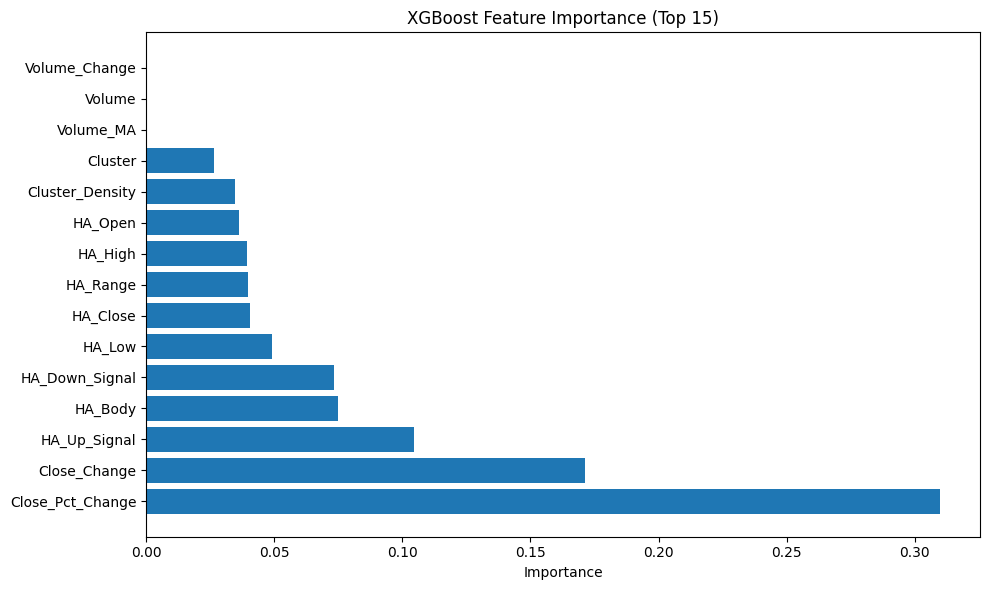


Feature importance plot saved


In [13]:
# Get feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance (Top 15)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=100)
plt.show()

print("\nFeature importance plot saved")

## 12. Generate Predictions for Backtesting

In [14]:
# Generate predictions for entire dataset (for backtesting)
df_with_features = df_clean.copy()

# Make sure we have all features
X_full = df_with_features[feature_cols].fillna(method='bfill').fillna(method='ffill')
X_full_scaled = scaler.transform(X_full)

# Predict
y_pred_full = model.predict(X_full_scaled)
y_pred_proba_full = model.predict_proba(X_full_scaled)

# Convert to ±1 format (to match LSTM and RF)
df_with_features['XGB_Prediction'] = np.where(y_pred_full == 1, 1, -1)
df_with_features['Confidence'] = np.max(y_pred_proba_full, axis=1)

# Create output CSV (matching LSTM/RF format)
forecast_df = df_with_features[['Time', 'XGB_Prediction']].copy()
forecast_df.to_csv('xgboost_ha15m_forecast.csv', index=False)

print('✓ Forecast saved: xgboost_ha15m_forecast.csv')
print(f'Shape: {forecast_df.shape}')
print(f'\nFirst 10 rows:')
print(forecast_df.head(10))
print(f'\nPrediction distribution:')
print(forecast_df['XGB_Prediction'].value_counts())

✓ Forecast saved: xgboost_ha15m_forecast.csv
Shape: (78382, 2)

First 10 rows:
                   Time  XGB_Prediction
12  2023-01-01 03:00:00              -1
28  2023-01-01 07:00:00              -1
63  2023-01-01 15:45:00               1
76  2023-01-01 19:00:00               1
80  2023-01-01 20:00:00              -1
96  2023-01-02 00:00:00               1
99  2023-01-02 00:45:00               1
100 2023-01-02 01:00:00              -1
110 2023-01-02 03:30:00               1
111 2023-01-02 03:45:00               1

Prediction distribution:
XGB_Prediction
 1    40189
-1    38193
Name: count, dtype: int64


## 13. Save Models and Data

In [16]:
# Save model
model.save_model('xgboost_ha15m_trend_model.json')
joblib.dump(model, 'xgboost_ha15m_trend_model.pkl')
print("✓ Model saved: xgboost_ha15m_trend_model.pkl")

# Save scaler
joblib.dump(scaler, 'scaler_ha15m_xgboost.save')
print("✓ Scaler saved: scaler_ha15m_xgboost.save")

# Forecast already saved in cell 12
print("✓ Forecast already saved: xgboost_ha15m_forecast.csv")

# Save training info
with open('training_info.txt', 'w') as f:
    f.write(f"BTCUSD 15m Heiken Ashi K-Means XGBoost Model\n")
    f.write(f"\nModel Performance:\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"ROC-AUC: {roc_auc:.4f}\n")
    f.write(f"\nFeature Count: {len(feature_cols)}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Test Samples: {len(X_test)}\n")

print("✓ Training info saved: training_info.txt")
print("\n=== TRAINING COMPLETE ===")

✓ Model saved: xgboost_ha15m_trend_model.pkl
✓ Scaler saved: scaler_ha15m_xgboost.save
✓ Forecast already saved: xgboost_ha15m_forecast.csv
✓ Training info saved: training_info.txt

=== TRAINING COMPLETE ===


## 14. Visualization: Price Action + Clusters + Signals

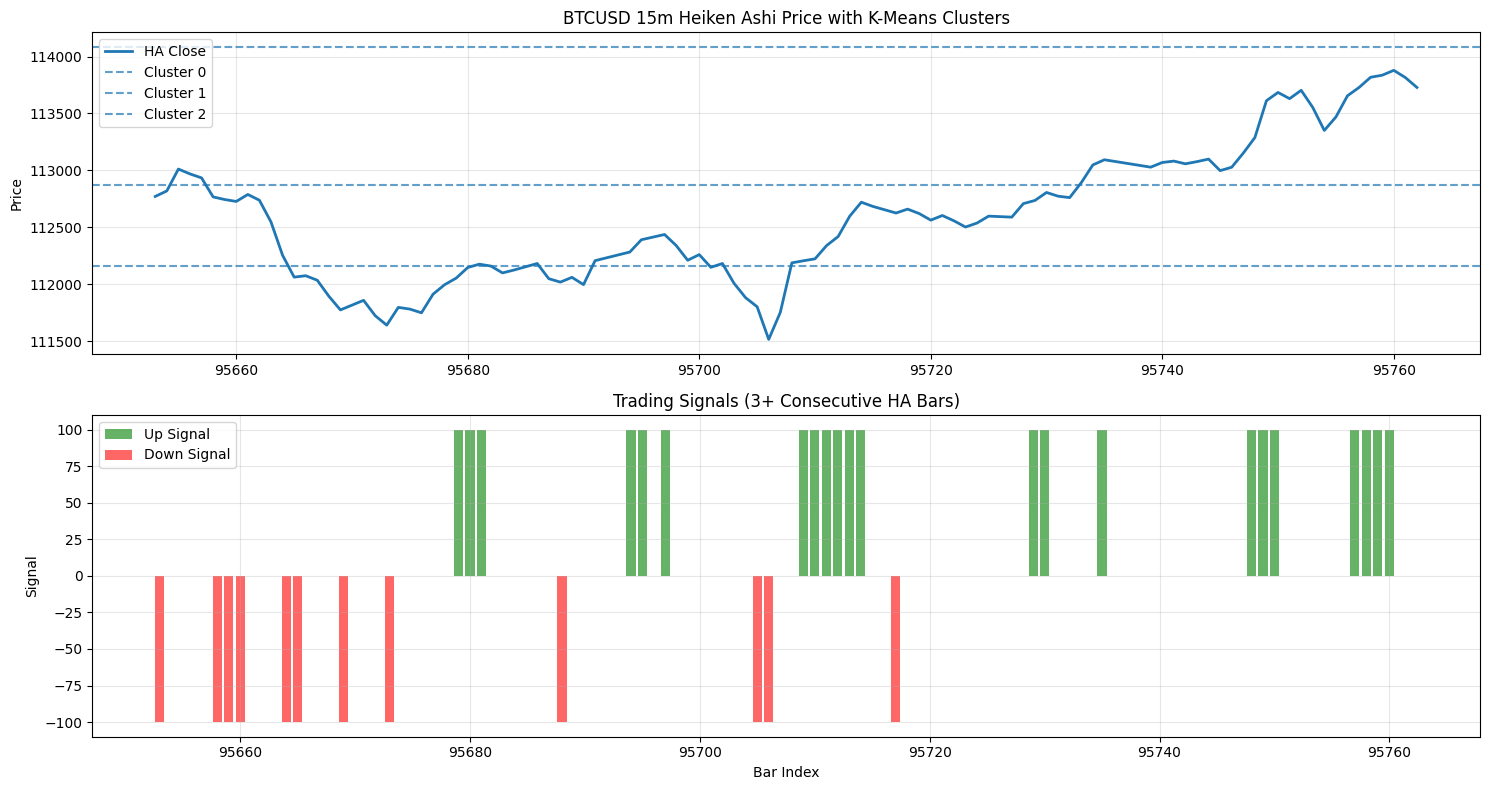

Chart saved: ha_kmeans_analysis.png


In [17]:
# Plot last 100 bars showing clusters and signals
plot_data = df_clean.tail(100).copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Price with clusters
ax1.plot(plot_data.index, plot_data['HA_Close'], label='HA Close', linewidth=2)
for i in range(k_clusters):
    cluster_price = kmeans.cluster_centers_[i][0]
    ax1.axhline(y=cluster_price, label=f'Cluster {i}', linestyle='--', alpha=0.7)

ax1.set_title('BTCUSD 15m Heiken Ashi Price with K-Means Clusters')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Signals
ax2.bar(plot_data.index, plot_data['HA_Up_Signal'] * 100, label='Up Signal', alpha=0.6, color='green')
ax2.bar(plot_data.index, -plot_data['HA_Down_Signal'] * 100, label='Down Signal', alpha=0.6, color='red')

ax2.set_title('Trading Signals (3+ Consecutive HA Bars)')
ax2.set_ylabel('Signal')
ax2.set_xlabel('Bar Index')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ha_kmeans_analysis.png', dpi=100)
plt.show()

print("Chart saved: ha_kmeans_analysis.png")